In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize, fmin_l_bfgs_b, fmin_ncg
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform

from bore.datasets import make_regression_dataset, make_classification_dataset
from bore.decorators import negate, unbatch, make_value_and_gradient_fn, numpy_outputs

In [2]:
K.set_floatx("float64")

num_samples = 15
num_features = 1

num_index_points = 512
xmin, xmax = -1.0, 2.0
X_grid = np.linspace(xmin, xmax, num_index_points).reshape(-1, num_features)

noise_variance = 0.2
quantile = 1/3

seed = 42
random_state = np.random.RandomState(seed)

In [3]:
def latent(x):
#     return (6.0*x-2.0)**2 * np.sin(12.0*x - 4.0)
    return np.sin(3.0*x) + x**2 - 0.7*x

In [4]:
load_observations = make_regression_dataset(latent)
X, y = load_observations(num_samples=num_samples,
                         num_features=num_features,
                         noise_variance=noise_variance,
                         x_min=xmin, x_max=xmax,
                         random_state=random_state)

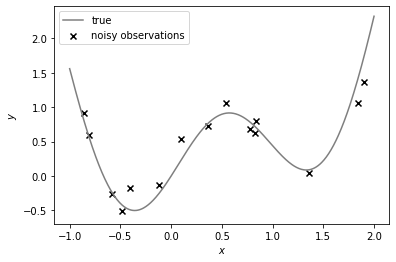

In [5]:
fig, ax = plt.subplots()

ax.plot(X_grid, latent(X_grid), label="true", color="tab:gray")
ax.scatter(X, y, marker='x', color='k', label="noisy observations")

ax.set_xlabel(r'$x$')
ax.set_ylabel(r"$y$")

ax.legend()

plt.show()

In [6]:
y_threshold = np.quantile(y, q=quantile)
y_threshold

0.37302270311064506

In [7]:
mask_lesser = (y <= y_threshold)
mask_greater = ~mask_lesser

In [8]:
X_lesser = X[mask_lesser]
X_greater = X[mask_greater]

In [9]:
# 
U, z = make_classification_dataset(X_lesser, X_greater)
U

array([[-0.58151842],
       [-0.12356605],
       [ 1.35552788],
       [-0.40097865],
       [-0.48842763],
       [ 0.83555868],
       [ 0.09908553],
       [ 0.36820995],
       [ 0.54270332],
       [ 0.77724371],
       [-0.86064876],
       [ 0.82263456],
       [-0.80484522],
       [ 1.84665661],
       [ 1.8968961 ]])

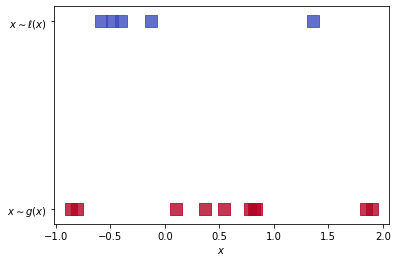

In [10]:
fig, ax = plt.subplots()

ax.scatter(U, z, c=z, s=12.**2,
           marker='s', alpha=0.8, cmap="coolwarm_r")
ax.set_yticks([0, 1])
ax.set_yticklabels([r"$x \sim g(x)$", r"$x \sim \ell(x)$"])
ax.set_xlabel('$x$')

plt.show()

In [11]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.regularizers import l2

def binary_crossentropy_from_logits(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred, from_logits=True)

In [12]:
model = Sequential([
    Dense(16, activation="elu", kernel_regularizer=l2(1e-3), kernel_initializer=GlorotUniform(seed=seed)),
    Dense(16, activation="elu", kernel_regularizer=l2(1e-3), kernel_initializer=GlorotUniform(seed=seed)),
#     Dense(32, activation="selu", kernel_initializer=GlorotUniform(seed=seed)),
#     Dense(16, activation="softplus", kernel_initializer=GlorotUniform(seed=seed)),
    Dense(1, kernel_initializer=GlorotUniform(seed=seed))
])
model.compile(optimizer="adam", loss=binary_crossentropy_from_logits, metrics=["accuracy"])

In [13]:
model.fit(U, z, epochs=800, batch_size=64)

Train on 15 samples
Epoch 1/800
15/15 [==============================] - 0s 29ms/sample - loss: 0.6402 - accuracy: 0.6667
Epoch 2/800
15/15 [==============================] - 0s 231us/sample - loss: 0.6366 - accuracy: 0.6667
Epoch 3/800
15/15 [==============================] - 0s 210us/sample - loss: 0.6332 - accuracy: 0.6667
Epoch 4/800
15/15 [==============================] - 0s 795us/sample - loss: 0.6300 - accuracy: 0.6667
Epoch 5/800
15/15 [==============================] - 0s 431us/sample - loss: 0.6269 - accuracy: 0.6667
Epoch 6/800
15/15 [==============================] - 0s 418us/sample - loss: 0.6241 - accuracy: 0.6667
Epoch 7/800
15/15 [==============================] - 0s 339us/sample - loss: 0.6214 - accuracy: 0.6000
Epoch 8/800
15/15 [==============================] - 0s 418us/sample - loss: 0.6189 - accuracy: 0.6000
Epoch 9/800
15/15 [==============================] - 0s 437us/sample - loss: 0.6166 - accuracy: 0.5333
Epoch 10/800
15/15 [==============================] - 

Epoch 80/800
15/15 [==============================] - 0s 443us/sample - loss: 0.5908 - accuracy: 0.6667
Epoch 81/800
15/15 [==============================] - 0s 244us/sample - loss: 0.5907 - accuracy: 0.6667
Epoch 82/800
15/15 [==============================] - 0s 225us/sample - loss: 0.5907 - accuracy: 0.6667
Epoch 83/800
15/15 [==============================] - 0s 185us/sample - loss: 0.5906 - accuracy: 0.6667
Epoch 84/800
15/15 [==============================] - 0s 229us/sample - loss: 0.5905 - accuracy: 0.6667
Epoch 85/800
15/15 [==============================] - 0s 200us/sample - loss: 0.5904 - accuracy: 0.6667
Epoch 86/800
15/15 [==============================] - 0s 234us/sample - loss: 0.5903 - accuracy: 0.6667
Epoch 87/800
15/15 [==============================] - 0s 282us/sample - loss: 0.5903 - accuracy: 0.6667
Epoch 88/800
15/15 [==============================] - 0s 277us/sample - loss: 0.5902 - accuracy: 0.6667
Epoch 89/800
15/15 [==============================] - 0s 210us/s

Epoch 159/800
15/15 [==============================] - 0s 668us/sample - loss: 0.5836 - accuracy: 0.6667
Epoch 160/800
15/15 [==============================] - 0s 220us/sample - loss: 0.5835 - accuracy: 0.6667
Epoch 161/800
15/15 [==============================] - 0s 204us/sample - loss: 0.5834 - accuracy: 0.6667
Epoch 162/800
15/15 [==============================] - 0s 329us/sample - loss: 0.5833 - accuracy: 0.6667
Epoch 163/800
15/15 [==============================] - 0s 187us/sample - loss: 0.5832 - accuracy: 0.6667
Epoch 164/800
15/15 [==============================] - 0s 219us/sample - loss: 0.5831 - accuracy: 0.6667
Epoch 165/800
15/15 [==============================] - 0s 477us/sample - loss: 0.5830 - accuracy: 0.6667
Epoch 166/800
15/15 [==============================] - 0s 189us/sample - loss: 0.5829 - accuracy: 0.6667
Epoch 167/800
15/15 [==============================] - 0s 217us/sample - loss: 0.5828 - accuracy: 0.6667
Epoch 168/800
15/15 [==============================] - 

15/15 [==============================] - 0s 262us/sample - loss: 0.5743 - accuracy: 0.6667
Epoch 238/800
15/15 [==============================] - 0s 283us/sample - loss: 0.5741 - accuracy: 0.6667
Epoch 239/800
15/15 [==============================] - 0s 246us/sample - loss: 0.5740 - accuracy: 0.6667
Epoch 240/800
15/15 [==============================] - 0s 237us/sample - loss: 0.5739 - accuracy: 0.6667
Epoch 241/800
15/15 [==============================] - 0s 297us/sample - loss: 0.5737 - accuracy: 0.6667
Epoch 242/800
15/15 [==============================] - 0s 280us/sample - loss: 0.5736 - accuracy: 0.6667
Epoch 243/800
15/15 [==============================] - 0s 228us/sample - loss: 0.5734 - accuracy: 0.6667
Epoch 244/800
15/15 [==============================] - 0s 229us/sample - loss: 0.5733 - accuracy: 0.6667
Epoch 245/800
15/15 [==============================] - 0s 370us/sample - loss: 0.5731 - accuracy: 0.6667
Epoch 246/800
15/15 [==============================] - 0s 291us/sampl

Epoch 316/800
15/15 [==============================] - 0s 199us/sample - loss: 0.5598 - accuracy: 0.6667
Epoch 317/800
15/15 [==============================] - 0s 217us/sample - loss: 0.5595 - accuracy: 0.6667
Epoch 318/800
15/15 [==============================] - 0s 293us/sample - loss: 0.5593 - accuracy: 0.6667
Epoch 319/800
15/15 [==============================] - 0s 200us/sample - loss: 0.5590 - accuracy: 0.6667
Epoch 320/800
15/15 [==============================] - 0s 220us/sample - loss: 0.5587 - accuracy: 0.6667
Epoch 321/800
15/15 [==============================] - 0s 281us/sample - loss: 0.5585 - accuracy: 0.6667
Epoch 322/800
15/15 [==============================] - 0s 358us/sample - loss: 0.5582 - accuracy: 0.6667
Epoch 323/800
15/15 [==============================] - 0s 194us/sample - loss: 0.5580 - accuracy: 0.6667
Epoch 324/800
15/15 [==============================] - 0s 253us/sample - loss: 0.5577 - accuracy: 0.6667
Epoch 325/800
15/15 [==============================] - 

15/15 [==============================] - 0s 246us/sample - loss: 0.5276 - accuracy: 0.6667
Epoch 395/800
15/15 [==============================] - 0s 196us/sample - loss: 0.5270 - accuracy: 0.6667
Epoch 396/800
15/15 [==============================] - 0s 587us/sample - loss: 0.5263 - accuracy: 0.6667
Epoch 397/800
15/15 [==============================] - 0s 230us/sample - loss: 0.5257 - accuracy: 0.6667
Epoch 398/800
15/15 [==============================] - 0s 188us/sample - loss: 0.5251 - accuracy: 0.6667
Epoch 399/800
15/15 [==============================] - 0s 273us/sample - loss: 0.5244 - accuracy: 0.6667
Epoch 400/800
15/15 [==============================] - 0s 228us/sample - loss: 0.5238 - accuracy: 0.6667
Epoch 401/800
15/15 [==============================] - 0s 215us/sample - loss: 0.5231 - accuracy: 0.6667
Epoch 402/800
15/15 [==============================] - 0s 235us/sample - loss: 0.5224 - accuracy: 0.6667
Epoch 403/800
15/15 [==============================] - 0s 264us/sampl

Epoch 473/800
15/15 [==============================] - 0s 208us/sample - loss: 0.4590 - accuracy: 0.8667
Epoch 474/800
15/15 [==============================] - 0s 184us/sample - loss: 0.4579 - accuracy: 0.8667
Epoch 475/800
15/15 [==============================] - 0s 272us/sample - loss: 0.4569 - accuracy: 0.8667
Epoch 476/800
15/15 [==============================] - 0s 273us/sample - loss: 0.4558 - accuracy: 0.8667
Epoch 477/800
15/15 [==============================] - 0s 196us/sample - loss: 0.4547 - accuracy: 0.8667
Epoch 478/800
15/15 [==============================] - 0s 223us/sample - loss: 0.4536 - accuracy: 0.9333
Epoch 479/800
15/15 [==============================] - 0s 455us/sample - loss: 0.4526 - accuracy: 0.9333
Epoch 480/800
15/15 [==============================] - 0s 192us/sample - loss: 0.4515 - accuracy: 0.9333
Epoch 481/800
15/15 [==============================] - 0s 252us/sample - loss: 0.4504 - accuracy: 0.9333
Epoch 482/800
15/15 [==============================] - 

Epoch 552/800
15/15 [==============================] - 0s 228us/sample - loss: 0.3775 - accuracy: 0.9333
Epoch 553/800
15/15 [==============================] - 0s 220us/sample - loss: 0.3767 - accuracy: 0.9333
Epoch 554/800
15/15 [==============================] - 0s 175us/sample - loss: 0.3759 - accuracy: 0.9333
Epoch 555/800
15/15 [==============================] - 0s 286us/sample - loss: 0.3751 - accuracy: 0.9333
Epoch 556/800
15/15 [==============================] - 0s 216us/sample - loss: 0.3742 - accuracy: 0.9333
Epoch 557/800
15/15 [==============================] - 0s 295us/sample - loss: 0.3734 - accuracy: 0.9333
Epoch 558/800
15/15 [==============================] - 0s 186us/sample - loss: 0.3726 - accuracy: 0.9333
Epoch 559/800
15/15 [==============================] - 0s 246us/sample - loss: 0.3719 - accuracy: 0.9333
Epoch 560/800
15/15 [==============================] - 0s 281us/sample - loss: 0.3711 - accuracy: 0.9333
Epoch 561/800
15/15 [==============================] - 

15/15 [==============================] - 0s 245us/sample - loss: 0.3319 - accuracy: 0.9333
Epoch 631/800
15/15 [==============================] - 0s 259us/sample - loss: 0.3315 - accuracy: 0.9333
Epoch 632/800
15/15 [==============================] - 0s 262us/sample - loss: 0.3310 - accuracy: 0.9333
Epoch 633/800
15/15 [==============================] - 0s 381us/sample - loss: 0.3306 - accuracy: 0.9333
Epoch 634/800
15/15 [==============================] - 0s 248us/sample - loss: 0.3302 - accuracy: 0.9333
Epoch 635/800
15/15 [==============================] - 0s 433us/sample - loss: 0.3298 - accuracy: 0.9333
Epoch 636/800
15/15 [==============================] - 0s 239us/sample - loss: 0.3294 - accuracy: 0.9333
Epoch 637/800
15/15 [==============================] - 0s 240us/sample - loss: 0.3290 - accuracy: 0.9333
Epoch 638/800
15/15 [==============================] - 0s 539us/sample - loss: 0.3285 - accuracy: 0.9333
Epoch 639/800
15/15 [==============================] - 0s 185us/sampl

Epoch 709/800
15/15 [==============================] - 0s 192us/sample - loss: 0.2987 - accuracy: 0.9333
Epoch 710/800
15/15 [==============================] - 0s 262us/sample - loss: 0.2982 - accuracy: 0.9333
Epoch 711/800
15/15 [==============================] - 0s 213us/sample - loss: 0.2977 - accuracy: 0.9333
Epoch 712/800
15/15 [==============================] - 0s 245us/sample - loss: 0.2973 - accuracy: 0.9333
Epoch 713/800
15/15 [==============================] - 0s 186us/sample - loss: 0.2968 - accuracy: 0.9333
Epoch 714/800
15/15 [==============================] - 0s 445us/sample - loss: 0.2963 - accuracy: 0.9333
Epoch 715/800
15/15 [==============================] - 0s 206us/sample - loss: 0.2958 - accuracy: 0.9333
Epoch 716/800
15/15 [==============================] - 0s 201us/sample - loss: 0.2953 - accuracy: 0.9333
Epoch 717/800
15/15 [==============================] - 0s 189us/sample - loss: 0.2949 - accuracy: 0.9333
Epoch 718/800
15/15 [==============================] - 

15/15 [==============================] - 0s 227us/sample - loss: 0.2545 - accuracy: 0.9333
Epoch 788/800
15/15 [==============================] - 0s 257us/sample - loss: 0.2538 - accuracy: 0.9333
Epoch 789/800
15/15 [==============================] - 0s 194us/sample - loss: 0.2531 - accuracy: 0.9333
Epoch 790/800
15/15 [==============================] - 0s 469us/sample - loss: 0.2525 - accuracy: 0.9333
Epoch 791/800
15/15 [==============================] - 0s 257us/sample - loss: 0.2518 - accuracy: 0.9333
Epoch 792/800
15/15 [==============================] - 0s 205us/sample - loss: 0.2511 - accuracy: 0.9333
Epoch 793/800
15/15 [==============================] - 0s 262us/sample - loss: 0.2504 - accuracy: 0.9333
Epoch 794/800
15/15 [==============================] - 0s 276us/sample - loss: 0.2498 - accuracy: 0.9333
Epoch 795/800
15/15 [==============================] - 0s 196us/sample - loss: 0.2491 - accuracy: 0.9333
Epoch 796/800
15/15 [==============================] - 0s 352us/sampl

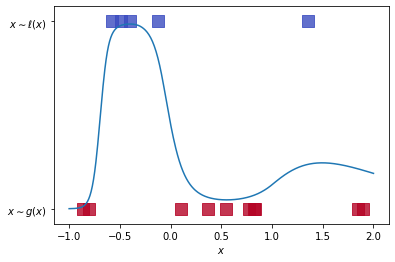

In [14]:
fig, ax = plt.subplots()

ax.scatter(U, z, c=z, s=12.**2,
           marker='s', alpha=0.8, cmap="coolwarm_r")
ax.set_yticks([0, 1])
ax.set_yticklabels([r"$x \sim g(x)$", r"$x \sim \ell(x)$"])
ax.set_xlabel('$x$')

ax.plot(X_grid, tf.sigmoid(model(X_grid)))

plt.show()

In [15]:
import statsmodels.api as sm

In [16]:
kde_lesser = sm.nonparametric.KDEUnivariate(X_lesser)
kde_lesser.fit(bw="normal_reference")

kde_greater = sm.nonparametric.KDEUnivariate(X_greater)
kde_greater.fit(bw="normal_reference")

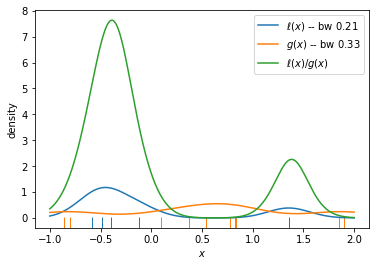

In [17]:
fig, ax = plt.subplots()

ax.plot(X_grid, kde_lesser.evaluate(X_grid.squeeze()),
        label=fr"$\ell(x)$ -- bw {kde_lesser.bw:.2f}")
ax.plot(X_grid, kde_greater.evaluate(X_grid.squeeze()),
        label=fr"$g(x)$ -- bw {kde_greater.bw:.2f}")

ax.plot(X_grid, kde_lesser.evaluate(X_grid.squeeze()) / kde_greater.evaluate(X_grid.squeeze()),
        label=r'$\ell(x) / g(x)$')
# ax.plot(X_grid, tf.exp(model(X_grid)), label="mlp")

sns.rugplot(X_lesser, c='tab:blue', ax=ax)
sns.rugplot(X_greater, c='tab:orange', ax=ax)

# ax.set_xscale("log")
ax.set_xlabel(r'$x$')
ax.set_ylabel("density")

ax.legend()

plt.show()

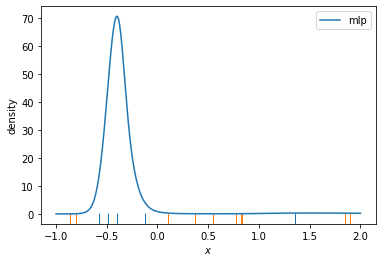

In [18]:
fig, ax = plt.subplots()

# ax.plot(X_grid, kde_lesser.evaluate(X_grid.squeeze()),
#         label=fr"$\ell(x)$ -- bw {kde_lesser.bw:.2f}")
# ax.plot(X_grid, kde_greater.evaluate(X_grid.squeeze()),
#         label=fr"$g(x)$ -- bw {kde_greater.bw:.2f}")

# ax.plot(X_grid, kde_lesser.evaluate(X_grid.squeeze()) / kde_greater.evaluate(X_grid.squeeze()),
#         label=r'$\ell(x) / g(x)$')
ax.plot(X_grid, tf.exp(model(X_grid)), label="mlp")

sns.rugplot(X_lesser, c='tab:blue', ax=ax)
sns.rugplot(X_greater, c='tab:orange', ax=ax)

# ax.set_xscale("log")
ax.set_xlabel(r'$x$')
ax.set_ylabel("density")

ax.legend()

plt.show()

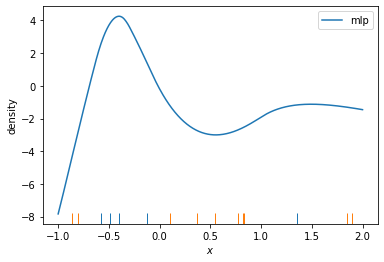

In [19]:
fig, ax = plt.subplots()

ax.plot(X_grid, model(X_grid), label="mlp")

sns.rugplot(X_lesser, c='tab:blue', ax=ax)
sns.rugplot(X_greater, c='tab:orange', ax=ax)

# ax.set_xscale("log")
ax.set_xlabel(r'$x$')
ax.set_ylabel("density")

ax.legend()

plt.show()

In [20]:
k = 16

In [21]:
val, grad = tfp.math.value_and_gradient(model, np.float64(X_grid[::k]))


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
learning_rate = 0.004

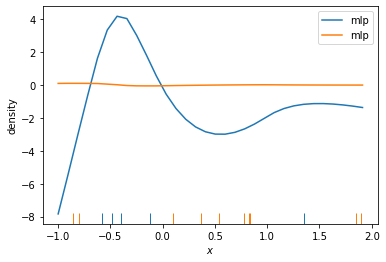

In [23]:
fig, ax = plt.subplots()

ax.plot(X_grid[::k], val, label="mlp")
ax.plot(X_grid[::k], learning_rate * grad, label="mlp")

sns.rugplot(X_lesser, c='tab:blue', ax=ax)
sns.rugplot(X_greater, c='tab:orange', ax=ax)

# ax.set_xscale("log")
ax.set_xlabel(r'$x$')
ax.set_ylabel("density")

ax.legend()

plt.show()

In [24]:
new_val = model(X_grid[::k] + learning_rate * grad)
new_val

<tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[-5.35167445],
       [-2.79101537],
       [-0.43500067],
       [ 1.75385491],
       [ 3.30615565],
       [ 3.9357257 ],
       [ 4.23438386],
       [ 4.21167747],
       [ 3.61082826],
       [ 2.49240098],
       [ 1.25520082],
       [-0.09295546],
       [-1.15358132],
       [-1.93789225],
       [-2.4826099 ],
       [-2.82084824],
       [-2.98094073],
       [-2.98698262],
       [-2.8640268 ],
       [-2.63457429],
       [-2.32375469],
       [-1.9622744 ],
       [-1.63758793],
       [-1.41120172],
       [-1.26068717],
       [-1.17131129],
       [-1.13065811],
       [-1.12850887],
       [-1.15660718],
       [-1.20837765],
       [-1.27864257],
       [-1.36336083]])>

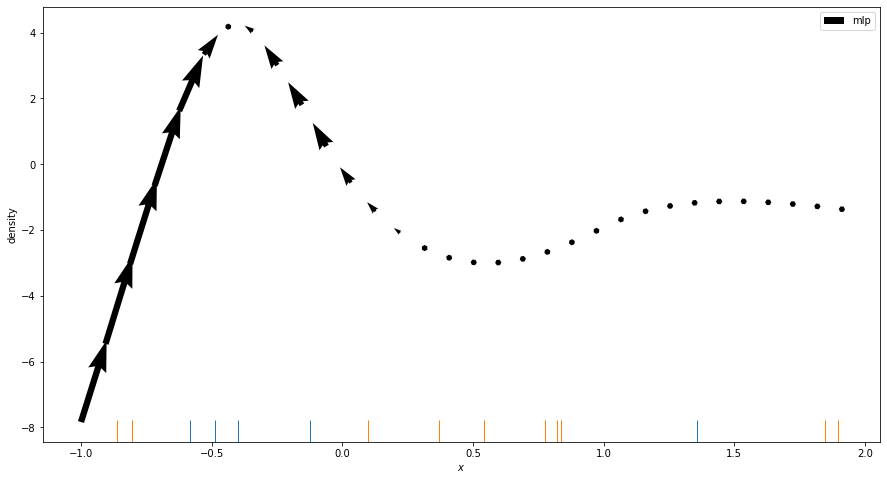

In [25]:
fig, ax = plt.subplots(figsize=(15, 8))

# ax.plot(X_grid[::k], val, label="mlp")
ax.quiver(X_grid[::k], val, learning_rate * grad, new_val - val, 
          scale_units='xy', angles='xy', scale=1.0, label="mlp")

sns.rugplot(X_lesser, c='tab:blue', ax=ax)
sns.rugplot(X_greater, c='tab:orange', ax=ax)

# ax.set_xscale("log")
ax.set_xlabel(r'$x$')
ax.set_ylabel("density")

ax.legend()

plt.show()

In [48]:
initial_position = random_state.uniform(low=xmin, high=xmax, size=(1,))
initial_position

array([-0.08615869])

In [49]:
@make_value_and_gradient_fn
@unbatch
@negate
def func(x):

    return model(x)

In [50]:
func(initial_position)

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.8921172523123378>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([13.494839], dtype=float32)>)

In [51]:
result = tfp.optimizer.lbfgs_minimize(func, initial_position=initial_position)

In [52]:
result

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=True>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=False>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=4>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=13>, position=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.40029316])>, objective_value=<tf.Tensor: shape=(), dtype=float64, numpy=-4.257101708363984>, objective_gradient=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.16351373e-13])>, position_deltas=<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.34349088],
       [ 0.02725299],
       [ 0.00210304]])>, gradient_deltas=<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.      

In [53]:
result.converged

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [54]:
result.failed

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [55]:
result.num_iterations

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [56]:
result.num_objective_evaluations

<tf.Tensor: shape=(), dtype=int32, numpy=13>

In [57]:
result.position

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.40029316])>

In [58]:
result.objective_value

<tf.Tensor: shape=(), dtype=float64, numpy=-4.257101708363984>

In [59]:
result.objective_gradient

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.16351373e-13])>

In [60]:
numpy_outputs(func)(initial_position)

(-0.8921172523123378, array([13.494839], dtype=float32))

In [61]:
initial_position

array([-0.08615869])

In [62]:
numpy_outputs(func)(initial_position)

(-0.8921172523123378, array([13.494839], dtype=float32))

In [63]:
@numpy_outputs
@make_value_and_gradient_fn
@unbatch
@negate
def func(x):

    return model(x)

In [64]:
initial_position.dtype

dtype('float64')

In [65]:
func(initial_position)

(-0.8921172523123378, array([13.494839], dtype=float32))

In [66]:
minimize(func, x0=initial_position, jac=True, method="L-BFGS-B", callback=print)

ValueError: failed to initialize intent(inout) array -- expected elsize=8 but got 4